In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats 
import os,json

import pymysql
pymysql.install_as_MySQLdb()

from sqlalchemy import create_engine 
from sqlalchemy_utils import create_database, database_exists

from tqdm.notebook import tqdm_notebook

In [2]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Question 1 
- Do smokers have higher insurance charges than non-smokers? 

## Hypothesis Testing

- Null Hypothesis: Both smokers and non-smokers have the same insurance charges 
- Alternative Hypothesis Testing: Smokers have higher insurance charges than non-smokers 
- Alpha = .05 

## 1.2 Correct Test- Two sample T-Test

- Numeric data-- insurance charges and counts 
- 2 groups 
- Two Sample T-Test

## Seperate Data into two groups

In [3]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [4]:
df['charges'].describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
df['has_smoked'] = df['smoker'] == 'yes'

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         1338 non-null   int64  
 1   sex         1338 non-null   object 
 2   bmi         1338 non-null   float64
 3   children    1338 non-null   int64  
 4   smoker      1338 non-null   object 
 5   region      1338 non-null   object 
 6   charges     1338 non-null   float64
 7   has_smoked  1338 non-null   bool   
dtypes: bool(1), float64(2), int64(2), object(3)
memory usage: 74.6+ KB


In [8]:
columns_needed = ['has_smoked', 'charges']

In [9]:
smoked_df = df.loc[df['has_smoked']==True, columns_needed]
smoked_df

,has_smoked,charges
0,True,16884.92400
11,True,27808.72510
14,True,39611.75770
19,True,36837.46700
23,True,37701.87680
...,...,...
1313,True,36397.57600
1314,True,18765.87545
1321,True,28101.33305
1323,True,43896.37630


In [10]:
nonsmoker_df = df.loc[df['has_smoked']==False, columns_needed]
nonsmoker_df

,has_smoked,charges
1,False,1725.55230
2,False,4449.46200
3,False,21984.47061
4,False,3866.85520
5,False,3756.62160
...,...,...
1332,False,11411.68500
1333,False,10600.54830
1334,False,2205.98080
1335,False,1629.83350


In [11]:
plot_df = pd.concat([smoked_df, nonsmoker_df])
plot_df

,has_smoked,charges
0,True,16884.9240
11,True,27808.7251
14,True,39611.7577
19,True,36837.4670
23,True,37701.8768
...,...,...
1332,False,11411.6850
1333,False,10600.5483
1334,False,2205.9808
1335,False,1629.8335


<AxesSubplot:xlabel='has_smoked', ylabel='charges'>

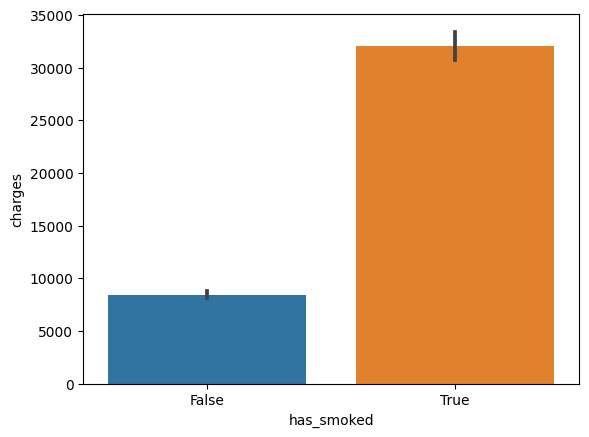

In [12]:
sns.barplot(data=plot_df, x='has_smoked', y='charges')

In [13]:
smoker_group = smoked_df['charges']



In [14]:
nonsmoker_group = nonsmoker_df['charges']

In [15]:
display(smoker_group.head(), nonsmoker_group.head())

0     16884.9240
11    27808.7251
14    39611.7577
19    36837.4670
23    37701.8768
Name: charges, dtype: float64

1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
5     3756.62160
Name: charges, dtype: float64

## Checking Assumptions

In [16]:
smoker_out = np.abs(stats.zscore(smoker_group)) > 3

In [18]:
smoker_out.sum()

0

In [19]:
nonsmoker_out = np.abs(stats.zscore(nonsmoker_group)) > 3

In [20]:
nonsmoker_out.sum()

24

In [21]:
nonsmoker_group = nonsmoker_group.loc[~nonsmoker_out]

In [22]:
result = stats.normaltest(smoker_group)

In [23]:
result.pvalue

5.564930630036463e-14

In [24]:
result = stats.normaltest(nonsmoker_group)
result.pvalue

2.6945416315543976e-36

In [25]:
result = stats.levene(smoker_group, nonsmoker_group)
print(result)

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)


In [26]:
result = stats.ttest_ind(smoker_group, nonsmoker_group, equal_var=False)
print(result)
result.pvalue > .05

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)


False

In [28]:
smoker_group.mean().round(2)

32050.23

In [29]:
nonsmoker_group.mean().round(2)

7939.86

In [30]:
plot_df = pd.concat([smoked_df, nonsmoker_df.loc[-nonsmoker_out]], axis=0) 
plot_df

,has_smoked,charges
0,True,16884.9240
11,True,27808.7251
14,True,39611.7577
19,True,36837.4670
23,True,37701.8768
...,...,...
1332,False,11411.6850
1333,False,10600.5483
1334,False,2205.9808
1335,False,1629.8335


<AxesSubplot:xlabel='has_smoked', ylabel='charges'>

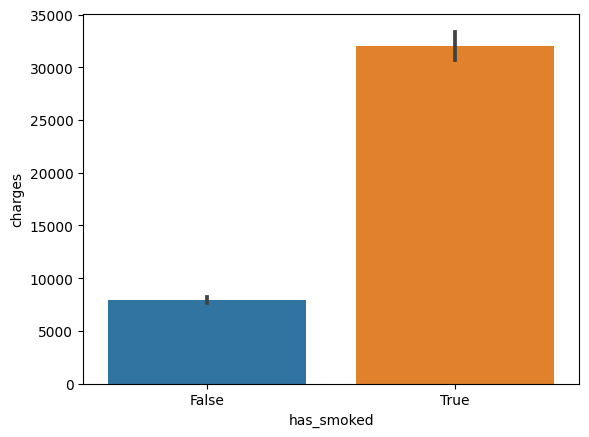

In [32]:
sns.barplot(data=plot_df, x='has_smoked', y='charges')


## Conclusion
- Our p-value is less than .05 which means we will reject the null hypothesis and support the alternative that non-smokers have lower charges than smokers. 

# Are men more likely to smoke than women?

## Hypothesis
- Null Hypothesis: Men smoke the same as women. 
- Alternative Hypothesis: Men smokre more than women. 
- Alpha .05 

## Test? 
- Data is categorical 
- 2 groups 
- Chi-square test

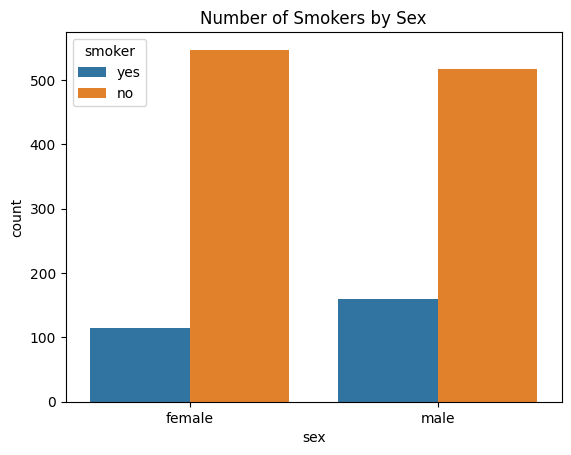

In [33]:
ax = sns.countplot(data=df, x='sex',hue='smoker',)
ax.set_title("Number of Smokers by Sex");

In [34]:
table = pd.crosstab(df['sex'], df['smoker'])

In [35]:
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [36]:
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result 

In [37]:
print(p)
p> .05

0.006548143503580696


False

## Conclusion
- p-value is less than .05, we will reject the null hypothesis and support that males are more likely to smoke than females. 

# Do different regions have different charges, on average?  

## Hypothesis
- Null Hypothesis: All regions have the same amount of charges on average.
- Alternative Hypothesis: Different regions have different charges on average. 
- Alpha .05 

In [38]:
df.head()

,age,sex,bmi,children,smoker,region,charges,has_smoked
0,19,female,27.900,0,yes,southwest,16884.92400,True
1,18,male,33.770,1,no,southeast,1725.55230,False
2,28,male,33.000,3,no,southeast,4449.46200,False
3,33,male,22.705,0,no,northwest,21984.47061,False
4,32,male,28.880,0,no,northwest,3866.85520,False


In [39]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

## Which test? 
- Data will be numerical 
- 4 groups 
- ANOVA Test

<AxesSubplot:xlabel='region', ylabel='charges'>

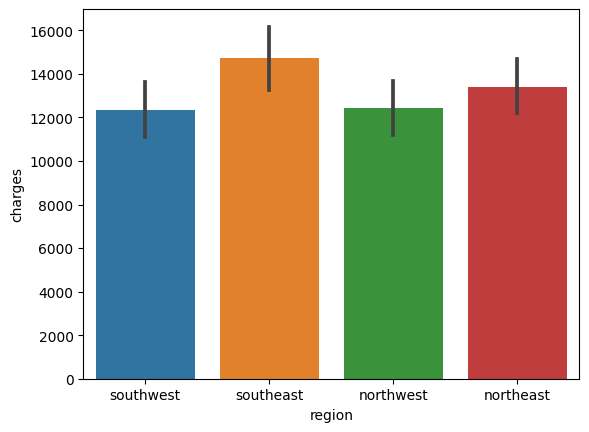

In [40]:
sns.barplot(data=df, x='region', y='charges')

In [43]:
groups = {}
## Loop through all unique categories
for i in df['region'].unique():
    ## Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [44]:
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,325.0,6.125298e-23,102.294059
southeast,364.0,4.953297e-15,65.877446
northwest,325.0,5.184209e-24,107.232850
northeast,324.0,1.455431e-19,86.747629


In [45]:
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df



,n,p,test stat,sig
southwest,325.0,6.125298e-23,102.294059,True
southeast,364.0,4.953297e-15,65.877446,True
northwest,325.0,5.184209e-24,107.232850,True
northeast,324.0,1.455431e-19,86.747629,True


In [46]:
# with the * operator 
stats.levene(*groups.values())


LeveneResult(statistic=5.559966758410606, pvalue=0.0008610590250786703)

## Variance
- Variance is unequal. 

In [52]:
# perform the correct hypothesis test
# note again the use of the * operator for convenience
result = stats.f_oneway( *groups.values())
result



F_onewayResult(statistic=2.96962669358912, pvalue=0.0308933560705201)

## In Conclusion
- Our Pvalue is less than .05 and we will reject the null hypothesis and support the alternative hypothesis which is different regions have different charges-- on average.

In [53]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
values = df['charges']
labels = df['region']



In [56]:
tukeys_results = pairwise_tukeyhsd(values, labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


### However, when compared to one another, there is only one group that we reject the null hypothesis. When comparing southeast to southwest, we reject the null hypothesis.